# Simple model without closed-form solution

We based our previous chapters on an intuitive example: tossing a coin and trying to find whether the probability of head is 0.5, i.e. whether our coin is biased. And we saw that we can use the Bayes Theorem to obtain the probability of each value of $\Theta$ based on the observed data, based on which we can reach a principled decision.

In this chapter, we will use another example to illustrate that even for rather simple models, some units of the Bayes theorem might not have an analytical solution (you will see in a bit what that means), making computing the posterior difficult. Importantly, the reason we introduce that is to motivate the use of the bag of tricks this book is about: **Variational Laplace**. Once you understand why we can't simply solve the equation, it should be more intuitive to understand why we need to call on seemingly unrelated concepts.

The example we will use is also based on a simple question: is the length of penguins flippers related to their body mass? The reason we use this problem is two folds. For one, it enables us to illustrate the difficulties of Bayesian statistics with one of the most general model there is: the linear mixed model, which is also the most important for people reading coming from psychology and neuroscience. But also, it might be familiar from other tutorials online because of the Palmer penguin data set, which is used across many tutorials to illustrate basic principles of stats. In this chapter, we will rely on simulation rather than on the actual dataset, but we will get back to the actual data set in a later chapter. 

## The linear model:
To investigate this problem, we will use a linear model, which is defined as:

$$y = \beta_{0} + \beta_{1}x_{1} + \epsilon$$

Where:
- y: the data. In our example, that would be the body mass of the penguin
- $x_{1}$: a correlate. In our example, that would be the flipper length
- $\beta_{1}$: correlation coefficient. If the flipper length is related to the mass of the penguin, then the body weight may be $\beta_{1}$ times the flipper length
- $\beta_{0}$: intercept. If there is a linear relationship between the body weight and the flipper of the penguin, there may be an offset in that relationship (we will see below that that looks like)
- $\epsilon$ error term. The relationship between the flipper length and the body weight probably isn't 1 to 1, so there will be some error remaining that isn't explained by our model

### The linear model in action
Let's suppose that there is a positive correlation between the flipper length and the weight of the penguin. That would make sense, because it seems logical that penguin with larger flippers would be heavier. And also, as we said, we probably won't have a perfect relationship between flipper length and penguin's weight, so there will be some error remaining. So say we have a correlation of 0.19, plus some error, and an intercept of 0, the data would look something like that:

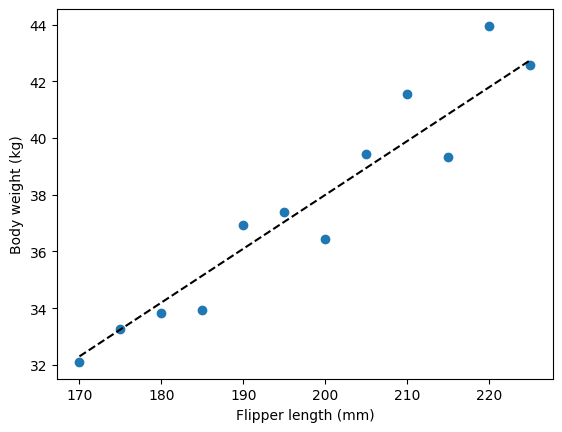

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def linear_mdl(x, beta_0, beta_1, error_mu, error_sigma):
    y = beta_0 + beta_1 * x + np.random.normal(error_mu, error_sigma, size=x.shape[0])
    return y

# Define the parameters for our simulation:
flipper_length_mm = np.arange(170, 230, 5)  # Let's say we collected the flipper length of penguins and that these are between 170 and 230mm
beta_0 = 0  # Intercept
beta_1 = 0.19  # Regression coefficient between flipper length and body weight 
error_mu = 0  # Mean error term
error_sigma = 1  # Error term spread

# Simulate the data:
y = linear_mdl(flipper_length_mm, beta_0, beta_1, error_mu, error_sigma)

# Plot the data:
fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y)  # Plot the simulated data
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='k', linestyle='--', label='Regression line')  # Plot the regression line
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
plt.show()
plt.close()

There we go, we have generated semi-realistic data: penguin flippers size is correlated with their body weights. A penguin with flippers of 200mm is going to weight around 36-38kg, while a penguin with flipper lengths of 170mm is most likely going to weight around 32-34kg. That doesn't seem too crazy, but full disclosure I am not a penguin experts, so I have no idea. 

### Digression: how does a linear model even works and how to fit them ?

(feel free to skip if you already know about them)

The example above should help you understand how the linear model helps determine if there is a relationship between two variables, so it is ultimately the same thing as running a correlation analysis. If there is a relationship between two variables, this means that when you fit a linear model to it, you should obtain a non-zero value for $\beta_1$. Conceptually, the way it works is that you try to fit balck dotted line above by trying any combination of parameters and consider the combination of parameters ($\beta_{0}$ and $\beta_{1}$) that minimize the error of the model as the most adequate. If the line that minimize the error best has a large $\beta_{1}$ value, chances are the two variables you are looking at are correlated.

What we mean by minimizing the error is trying to find a line that makes the error term as small as possible. In the graphic above, the error for each dot is how far away it is from the black dotted line. Here is way to vizualize it:

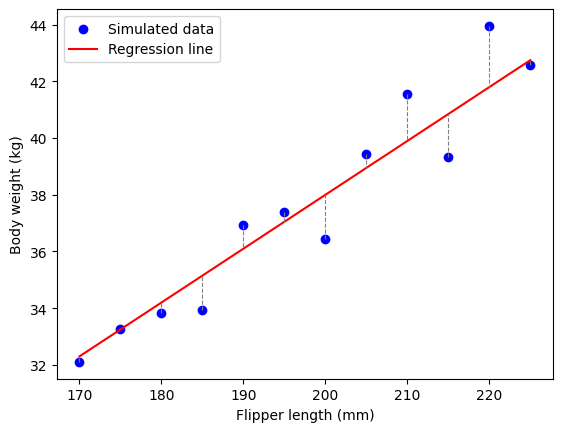

In [51]:
# Plot the data and regression line
fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y, label='Simulated data', color='blue')
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='red', label='Regression line')
# Add horizontal lines connecting each data point to the regression line
for i in range(len(flipper_length_mm)):
    ax.plot([flipper_length_mm[i], flipper_length_mm[i]], [y[i], beta_0 + beta_1 * flipper_length_mm[i]], color='gray', linestyle='--', linewidth=0.8)
# Set labels and legend
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
ax.legend()
# Show plot
plt.show()
plt.close()

That way, you can see that for each penguin (i.e. each dot), their weight is $\beta_1 * Flipper\ Length + some\ error$. If you take the left most dot, the weight is $170*0.19=32.3kg$ plus a little something. That little something is the error, and we need to find the parameter of our model so that the sum of the vertical distance between each dot and the regression line is as small as possible. For example, with the simulated data, the error will be larger when we use any other $\beta_1$ parameter:

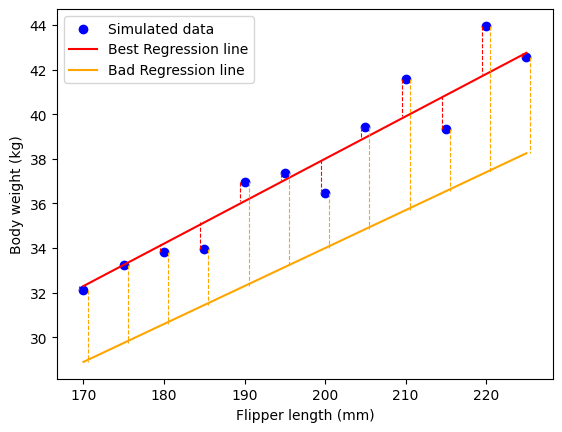

In [52]:
# Plot the data and regression line
fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y, label='Simulated data', color='blue')
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='red', label='Best Regression line')
ax.plot(flipper_length_mm, beta_0 + 0.17 * flipper_length_mm, color='orange', label='Bad Regression line')
# Add horizontal lines connecting each data point to the regression line
for i in range(len(flipper_length_mm)):
    ax.plot([flipper_length_mm[i]-0.5, flipper_length_mm[i]-0.5], [y[i], beta_0 + beta_1 * flipper_length_mm[i]], color='red', linestyle='--', linewidth=0.8)
    ax.plot([flipper_length_mm[i]+0.5, flipper_length_mm[i]+0.5], [y[i], beta_0 + 0.17 * flipper_length_mm[i]], color='orange', linestyle='--', linewidth=0.8)
# Set labels and legend
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
ax.legend()
# Show plot
plt.show()
plt.close()

You can see that the distance between the orange line and each dot is larger than the distance between the red line and each dot, which means that the red line does a better job at modelling the data. Formally, when we try to minimize the error, we try to minimize the **residual sum of square error**:

$$RSS = \sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

Which is basically saying we try to find the parameters $\beta_0$ and $\beta_1$ such that the sum of the difference between each blue dot ($y_i$) and the value predicted by the line ($\hat{y_i}$) is as small as possible. And we take the square of the difference such that it doesn't matter if the prediction is more or less than the true value. So you can imagine that fitting a linear model is trying all possible combinations of values of $\beta_0$ and $\beta_1$ (and other $\beta$ if you have several regressors) and for each compute the **RSS** and pick those values. And if the best parameters entail a large value for $\beta$, chances are that your two variables are correlated.

I think this description is nice to understand how we fit a linear model, i.e. how do we know which values should we choose for our parameters when we are given two random variables? But in practice, we don't actually try all possible combinations of $\beta_0$ and $\beta_1$. That is because that's simply impossible. As we saw in the previous chapters, $\beta_0$ and $\beta_1$ are continuous variables, meaning that there is an infinity of parameters to choose from. And also, we have two parameters to consider, so we have many combinations. Furthermore, while in our example we have only $\beta_0$ and $\beta_1$, but you can have as many $\beta$ as you want. So overall, it quickly becomes impractical to try out all possible combinations.

And it turns out we really don't have to, because once again someone figured out a simple math formulae to select the parameters of our model based on the input data without having to try all combination. This is achieved in a very similar way to what we did in the previous chapters. We won't go into all the details here (But consult this supplementary chapter if you are interested), but in a nutshell, you have the function:

$$y = \beta_{0} + \beta_{1}x_{1} + \epsilon$$

And you try to find:

$$RSS = \sum_{i=1}^{n}y_i-(\beta_{0} + \beta_{1}x_{1})^2$$

Such that RSS is as small as possible. And it turns out that that is:

$$\hat{\beta_1} = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$$

$$\hat{\beta_0} = \bar{y} - \hat{\beta_1}\bar{x}$$

Where $\bar{x}$ and $\bar{y}$ stand for the mean of x and y respectively. 

We can try it out programatically. If this formula works, we should retrieve values that are close from the parameters we used to generate the data:

In [53]:
def fit_linear_model(y, x):
    # Calculate beta_1:
    beta_1 = np.sum((x-np.mean(x))*(y-np.mean(y))) / np.sum((x-np.mean(x))**2)
    # Calcuate beta_0:
    beta_0 = np.mean(y) - beta_1 * np.mean(x)

    return beta_0, beta_1

beta_0, beta_1 = fit_linear_model(y, flipper_length_mm)
print(f'Estimated beta_1={np.round(beta_1, 3)}')
print(f'Estimated beta_0={np.round(beta_0, 3)}')

Estimated beta_1=0.206
Estimated beta_0=-3.154


As you can see, close enough, but perhaps surprisingly not exactly the same. This is because of the noise parameter, which makes it such that the data aren't exactly along the line. Accordingly, despite the true parameter of $\beta_1$ being 0.19, we don't get exactly that out when we fit the model. In fact, this is exactly the same idea as with the coin toss we had before: if we throw the coin 100 times, even if the true probability of getting head is 0.5 we don't always get 50% head in each experiment. In the current case, despite the true parameters beta being 0.19, because we only measured a few penguins, we don't get exactly the true parameter our anymore. And just as before, the whole question is: based on my data, how can I be confident that the true value of beta_1 is within a particular range? If our hypothesis is that there is a positive association between flipper size and body weight, we are predicting that it is most likely that beta_1 is more than 0. 

### The error term
As you probably saw in the programatic implementation of our model, the 'noise' $\epsilon$ was defined in a particular way. There were two parameters: mean (or $\mu$) and spread (or $\sigma$). You might wonder why that is. In a linear model, we are stating that the data are equal to $\beta_0 + \beta_1x + \epsilon$, and this $\epsilon$ is basically just some random fluctuation in our data that make it such that it doesn't simply follows the value predicted by $\beta_0 + \beta_1x$. In other words, this error term is the reason why the dots above don't fall exactly on the line. What could this error be? Well there can be an infinity of reasons why the weight of a penguin isn't fully determined by its flipper length. The weight of a penguin surely depends strongly on food availability for example. And food availability depends on the season: in fish season, penguins are probably a bit heavier than when there is little fish around. Furthermore, the weight of a penguin might also depends from its life history more than its flipper length: a penguin that had a comfortable life might be a bit chubbier, while a penguin that got dealt poorer cards in life might be a bit lighter (disclaimer: I am not proposing to eat the rich). And surely the length of the flipper might depend on genetic factors that are independent from the weight: some penguin may have quite disproportionately long flippers, the michael phelps of penguins if you like. But I digress again.

The point is that whatever variationb isn't described by $\beta_0$ and $\beta_1$ falls into the error term, which is random. But as we saw in the previous chapters, a random variables most often follows a particular probability distribution. Which one should that be for our model? The answer is the **Normal distribution**. If you heard about variational Laplace and were interested enough to keep reading until now, I would guess you know what the normal distribution is. If by a mirable you haven't, let's just say it is the single most important probability distribution in the world. You will encounter it times and times again, in this book and beyond. The formulae of the normal distribution is the following:

$$P(x) = \frac{1}{\sqrt{\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

Again, quite simple to implement programmatically:

In [54]:
def normal_pdf(x, mu, sigma):
    p_x = (1/(np.sqrt(2*np.pi*sigma**2))) * np.e**(-((x-mu)**2)/(2*sigma**2))
    return p_x

Now let's have a look at what that distribution looks like:

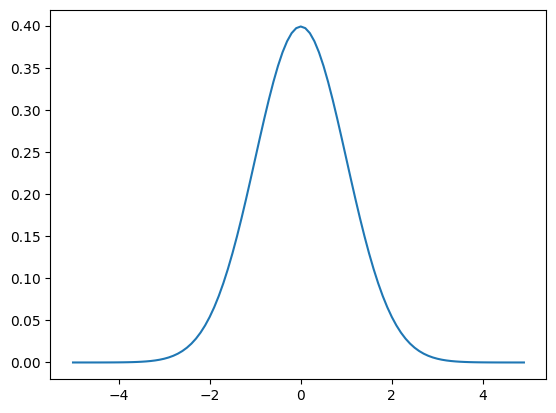

In [ ]:
xs = np.arange(-5, 5, 0.1)  # Define values of x
mu = 0
sigma = 1

# Compute the probability of each value of x:
pdf = [normal_pdf(x, mu, sigma) for x in xs]

fig, ax = plt.subplots()
ax.plot(xs, pdf, label=f'$\\mu=0$, $\\sigma=1$')
ax.set_ylabel('P(X=x)')
ax.set_xlabel('x')